In [46]:
file_path = "/Users/danielbarkan/mmuze-research/dresscode_rules_analysis/data_docs/shirt#female#dress_code_casual.csv"


In [47]:
import pandas as pd

In [48]:
df = pd.read_csv(file_path)

In [49]:
df.head()

,doc,class
0,product_type-shirt fabric-cotton fabric-viscos...,1
1,product_type-shirt fit-longline fit-regular_fi...,1
2,product_type-shirt cut-ruffle cut-concealed_bu...,1
3,product_type-shirt fabric-pure_cotton neckline...,1
4,product_type-shirt fabric-cotton neckline-coll...,1


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(token_pattern=r'[a-zA-Z][a-zA-Z_-]+')
X = vec.fit_transform(df["doc"])
dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [51]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_leaf = 5, max_depth= 5)
clf = clf.fit(dtm, df["class"])

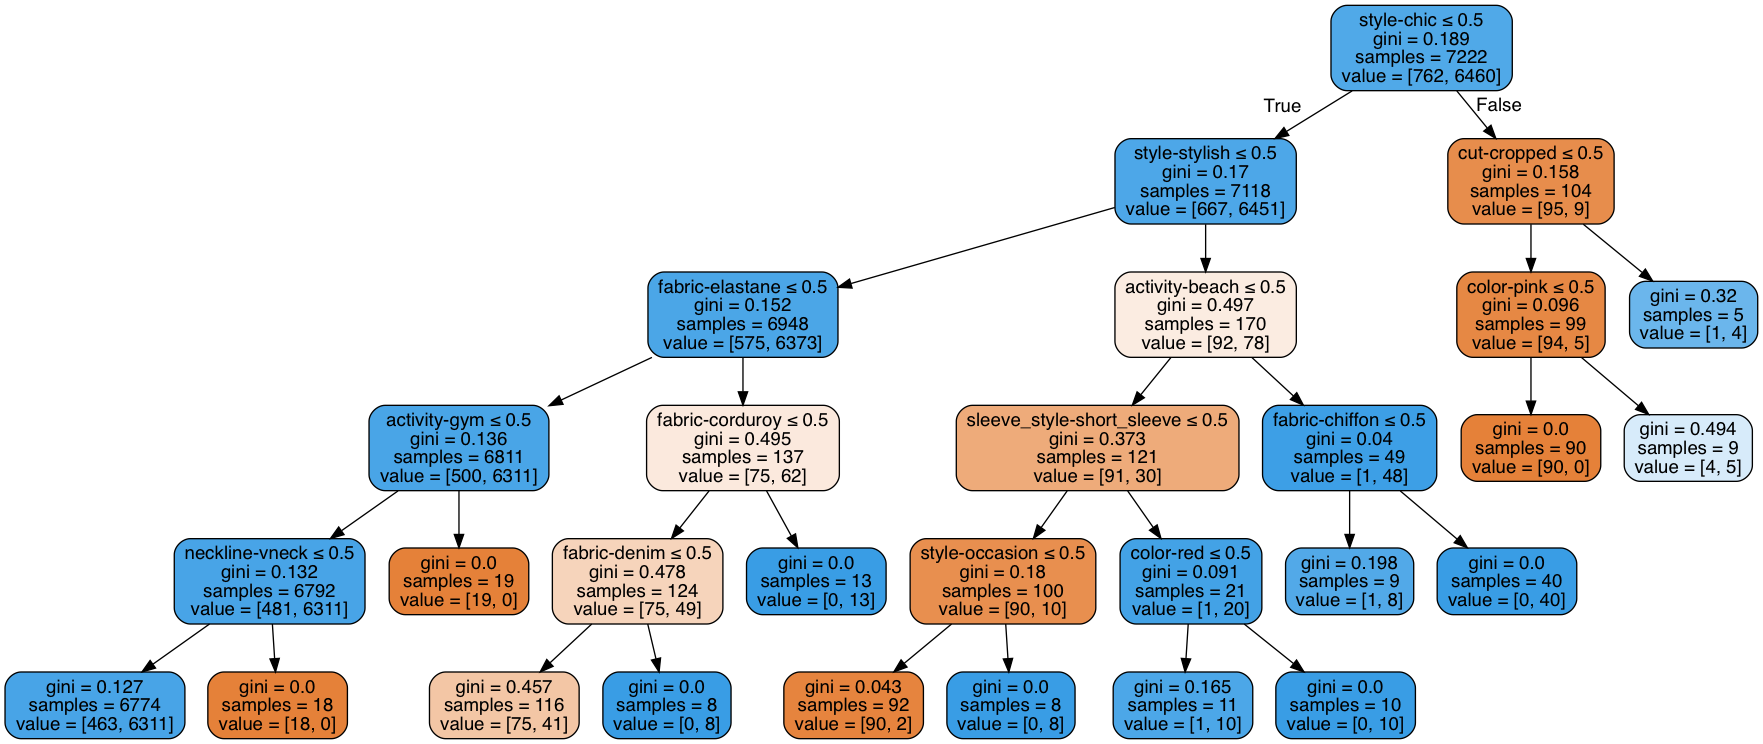

In [53]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names=dtm.columns,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [54]:
X = dtm
y = df["class"]

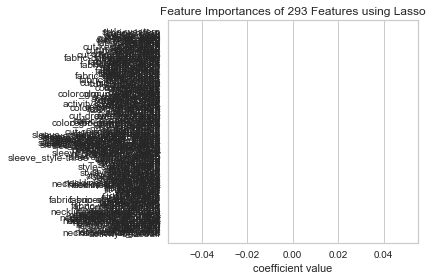

In [55]:

import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from yellowbrick.features.importances import FeatureImportances


# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()

# Title case the feature for better display and create the visualizer
#labels = list(map(lambda s: s.title(), features))
viz = FeatureImportances(Lasso(), ax=ax, labels=dtm.columns, relative=False)

# Fit and show the feature importances
viz.fit(X, y)
viz.poof()


In [56]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=1,
                             random_state=0)
rf.fit(X, y)

feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance',    ascending=False)                                                            

In [57]:
feature_importances[feature_importances["importance"] >0.001].sort_values('importance',    ascending=False)

,importance
fit-regular,0.10
length-short,0.08
color_group-bright,0.06
activity-yoga,0.04
cut-wrap,0.04
activity-gym,0.04
fabric-elastane,0.04
style-stylish,0.04
style-chic,0.04
style-occasion,0.04


In [60]:
import matplotlib.pyplot as plt
dtm["class"]=y
dtm.corr()["class"].sort_values(ascending=False)

class                         1.000000
color-pattern                 0.189287
fit-regular                   0.179576
length-short                  0.167977
fabric-polyester              0.128547
style-occasion                0.099216
neckline-collar               0.088534
fabric-knitted                0.083382
cut-cropped                   0.074049
sleeve_style-short_sleeve     0.060565
fabric-chiffon                0.058404
fit-relaxed                   0.051506
style-elegant                 0.044145
fit-baggy                     0.042008
fit-regular_fit               0.040197
fabric-spandex                0.039486
cut-hood                      0.038145
style-feminine                0.035239
style-vintage                 0.035173
cut-pocket                    0.034230
cut-zipper                    0.033978
sleeve_style-batwing          0.032219
style-classy                  0.031435
fabric-soft_material          0.031435
color_group-pattern           0.031370
cut-button_up            

In [37]:
df['']

,doc,class
0,product_type-shirt fabric-cotton fabric-viscos...,1
1,product_type-blouse fit-oversized fabric-woven...,1
2,product_type-shirt fit-longline fit-regular_fi...,1
3,product_type-blouse fabric-chiffon fabric-poly...,1
4,product_type-blouse fabric-woven fabric-polyes...,1


In [33]:
from skrules import SkopeRules
X_columns = [x.replace("-","_") for x in X.columns]
X.columns = X_columns
clf = SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.1,
                 recall_min=0.01,
                 feature_names=X.columns)

for idx in [1]:
    #X, y = dataset.data, dataset.target
    clf.fit(X, y == idx)
    rules = clf.rules_
    print("Rules")
    for rule in rules:
        print(rule[0])
    print()
    print(20*'=')
    print()

Rules
activity_gym <= 0.5 and color_pattern > 0.5 and style_chic <= 0.5
color_pattern <= 0.5 and fit_baggy <= 0.5 and style_occasion <= 0.5
color_pattern <= 0.5 and sleeve_style_raglan_sleeve <= 0.5 and style_occasion > 0.5




In [207]:
import numpy as np  
import pandas as pd  
from sklearn.tree import DecisionTreeClassifier 

def get_rules(dtc, df):
    rules_list = []
    values_path = []
    values = dtc.tree_.value

    def RevTraverseTree(tree, node, rules, pathValues):
        '''
        Traverase an skl decision tree from a node (presumably a leaf node)
        up to the top, building the decision rules. The rules should be
        input as an empty list, which will be modified in place. The result
        is a nested list of tuples: (feature, direction (left=-1), threshold).  
        The "tree" is a nested list of simplified tree attributes:
        [split feature, split threshold, left node, right node]
        '''
        # now find the node as either a left or right child of something
        # first try to find it as a left node            

        try:
            prevnode = tree[2].index(node)           
            leftright = '<='
            pathValues.append(values[prevnode])
        except ValueError:
            # failed, so find it as a right node - if this also causes an exception, something's really f'd up
            prevnode = tree[3].index(node)
            leftright = '>'
            pathValues.append(values[prevnode])

        # now let's get the rule that caused prevnode to -> node
        p1 = df.columns[tree[0][prevnode]]    
        p2 = tree[1][prevnode]    
        rules.append(str(p1) + ' ' + leftright + ' ' + str(p2))

        # if we've not yet reached the top, go up the tree one more step
        if prevnode != 0:
            RevTraverseTree(tree, prevnode, rules, pathValues)

    # get the nodes which are leaves
    leaves = dtc.tree_.children_left == -1
    leaves = np.arange(0,dtc.tree_.node_count)[leaves]

    # build a simpler tree as a nested list: [split feature, split threshold, left node, right node]
    thistree = [dtc.tree_.feature.tolist()]
    thistree.append(dtc.tree_.threshold.tolist())
    thistree.append(dtc.tree_.children_left.tolist())
    thistree.append(dtc.tree_.children_right.tolist())

    # get the decision rules for each leaf node & apply them
    for (ind,nod) in enumerate(leaves):

        # get the decision rules
        rules = []
        pathValues = []
        RevTraverseTree(thistree, nod, rules, pathValues)

        pathValues.insert(0, values[nod])      
        pathValues = list(reversed(pathValues))

        rules = list(reversed(rules))

        rules_list.append(rules)
        values_path.append(pathValues)

    return (rules_list, values_path)

In [208]:
get_rules(clf,X)

([['activity-gym <= 0.5',
   'cut-hood <= 0.5',
   'activity-run <= 0.5',
   'fit-tailored <= 0.5',
   'neckline-crew_neck <= 0.5'],
  ['activity-gym <= 0.5',
   'cut-hood <= 0.5',
   'activity-run <= 0.5',
   'fit-tailored <= 0.5',
   'neckline-crew_neck > 0.5'],
  ['activity-gym <= 0.5',
   'cut-hood <= 0.5',
   'activity-run <= 0.5',
   'fit-tailored > 0.5',
   'neckline-collar_button <= 0.5'],
  ['activity-gym <= 0.5',
   'cut-hood <= 0.5',
   'activity-run <= 0.5',
   'fit-tailored > 0.5',
   'neckline-collar_button > 0.5'],
  ['activity-gym <= 0.5', 'cut-hood <= 0.5', 'activity-run > 0.5'],
  ['activity-gym <= 0.5',
   'cut-hood > 0.5',
   'fabric-corduroy <= 0.5',
   'style-stylish <= 0.5',
   'color-pattern <= 0.5'],
  ['activity-gym <= 0.5',
   'cut-hood > 0.5',
   'fabric-corduroy <= 0.5',
   'style-stylish <= 0.5',
   'color-pattern > 0.5'],
  ['activity-gym <= 0.5',
   'cut-hood > 0.5',
   'fabric-corduroy <= 0.5',
   'style-stylish > 0.5',
   'body_type-plus_size <= 0.5'],

In [191]:
import numpy
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets, ensemble

def print_decision_rules(rf):

    for tree_idx, est in enumerate(rf.estimators_):
        tree = est.tree_
        assert tree.value.shape[1] == 1 # no support for multi-output

        print('TREE: {}'.format(tree_idx))

        iterator = enumerate(zip(tree.children_left, tree.children_right, tree.feature, tree.threshold, tree.value))
        for node_idx, data in iterator:
            left, right, feature, th, value = data

            # left: index of left child (if any)
            # right: index of right child (if any)
            # feature: index of the feature to check
            # th: the threshold to compare against
            # value: values associated with classes            

            # for classifier, value is 0 except the index of the class to return
            class_idx = numpy.argmax(value[0])

            if left == -1 and right == -1:
                print('{} LEAF: return class={}'.format(node_idx, class_idx))
            else:
                print('{} NODE: if feature[{}] < {} then next={} else next={}'.format(node_idx, feature, th, left, right))    

print_decision_rules(rf)

TREE: 0
0 NODE: if feature[98] < 0.5 then next=1 else next=8
1 NODE: if feature[17] < 0.5 then next=2 else next=5
2 NODE: if feature[239] < 0.5 then next=3 else next=4
3 LEAF: return class=1
4 LEAF: return class=0
5 NODE: if feature[43] < 0.5 then next=6 else next=7
6 LEAF: return class=1
7 LEAF: return class=1
8 NODE: if feature[39] < 0.5 then next=9 else next=12
9 NODE: if feature[194] < 0.5 then next=10 else next=11
10 LEAF: return class=0
11 LEAF: return class=1
12 NODE: if feature[306] < 0.5 then next=13 else next=14
13 LEAF: return class=1
14 LEAF: return class=0
TREE: 1
0 NODE: if feature[156] < 0.5 then next=1 else next=8
1 NODE: if feature[320] < 0.5 then next=2 else next=5
2 NODE: if feature[12] < 0.5 then next=3 else next=4
3 LEAF: return class=1
4 LEAF: return class=0
5 NODE: if feature[186] < 0.5 then next=6 else next=7
6 LEAF: return class=0
7 LEAF: return class=1
8 LEAF: return class=0
TREE: 2
0 NODE: if feature[332] < 0.5 then next=1 else next=8
1 NODE: if feature[223] 

In [197]:
tree.export_graphviz(clf,
    out_file='tree.dot') 

In [199]:
export_graphviz(clf,
      out_file='tree.dot',
      feature_names=X.columns)

In [200]:
dot -Tpng tree.dot -o tree.png

SyntaxError: invalid syntax (<ipython-input-200-70e48a2729eb>, line 1)